# Photometric Plugin

For optical photometry, we provide the **PhotometryLike** plugin that handles forward folding of a spectral model through filter curves. Let's have a look at the avaiable procedures.


In [1]:
import warnings

warnings.simplefilter("ignore")
import numpy as np

np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
%%capture
import matplotlib.pyplot as plt
from threeML import *

# we will need XPSEC models for extinction
from astromodels.xspec import *

# The filter library takes a while to load so you must import it explicitly.
from threeML.utils.photometry import get_photometric_filter_library

threeML_filter_library = get_photometric_filter_library()

In [3]:
from jupyterthemes import jtplot

%matplotlib inline
jtplot.style(context="talk", fscale=1, ticks=True, grid=False)
silence_warnings()
set_threeML_style()

## Setup

We use [speclite](http://speclite.readthedocs.io/en/latest/ ) to handle optical filters.
Therefore, you can easily build your own custom filters, use the built in speclite filters, or use the 3ML filter library that we have built thanks to [Spanish Virtual Observatory](http://svo.cab.inta-csic.es/main/index.php).

**If you use these filters, please be sure to cite the proper sources!**

### Simple example of building a filter
Let's say we have our own 1-m telescope with a Johnson filter and we happen to record the data. We also have simultaneous data at other wavelengths and we want to compare. Let's setup the optical plugin (we'll ignore the other data for now).



In [4]:
import speclite.filters as spec_filters

my_backyard_telescope_filter = spec_filters.load_filter("bessell-R")

# NOTE:
my_backyard_telescope_filter.name

'bessell-R'

NOTE: the filter name is 'bessell-R'. The plugin will look for the name *after* the **'-'** i.e 'R'


Now let's build a 3ML plugin via **PhotometryLike**.

Our data are entered as keywords with the name of the filter as the keyword and the data in an magnitude,error tuple, i.e. R=(mag,mag_err):

16:47:50 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=338751;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=303096;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

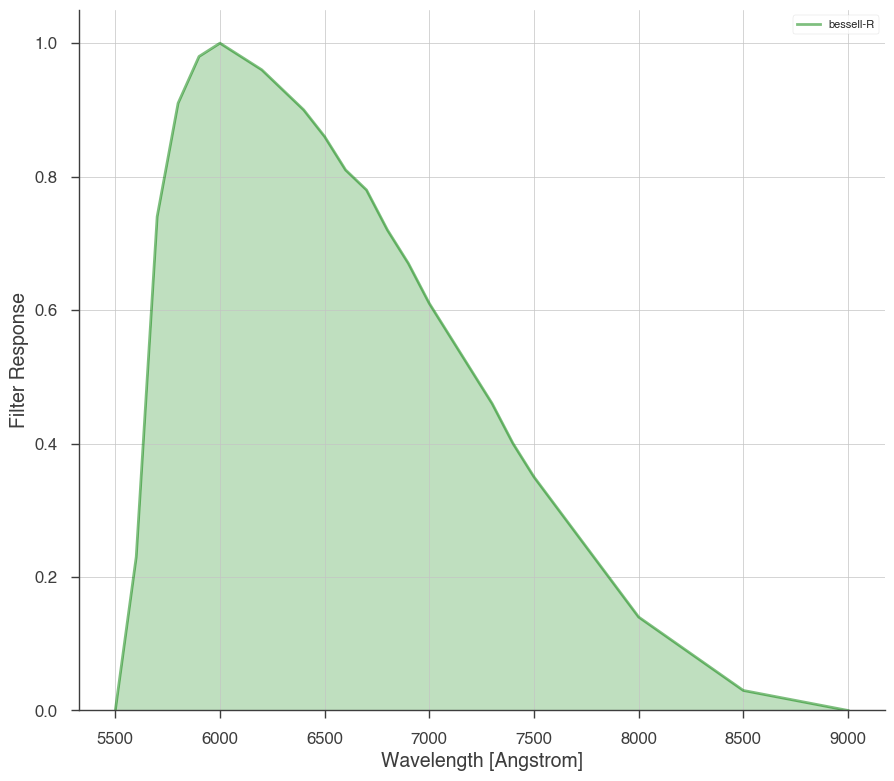

In [5]:
my_backyard_telescope = PhotometryLike.from_kwargs(
    "backyard_astronomy",
    filters=my_backyard_telescope_filter,  # the filter
    R=(20, 0.1),
)  # the magnitude and error

_ = my_backyard_telescope.display_filters()

## 3ML filter library
Explore the filter library. If you cannot find what you need, it is simple to add your own


In [6]:
threeML_filter_library.SLOAN

SDSS: SDSS

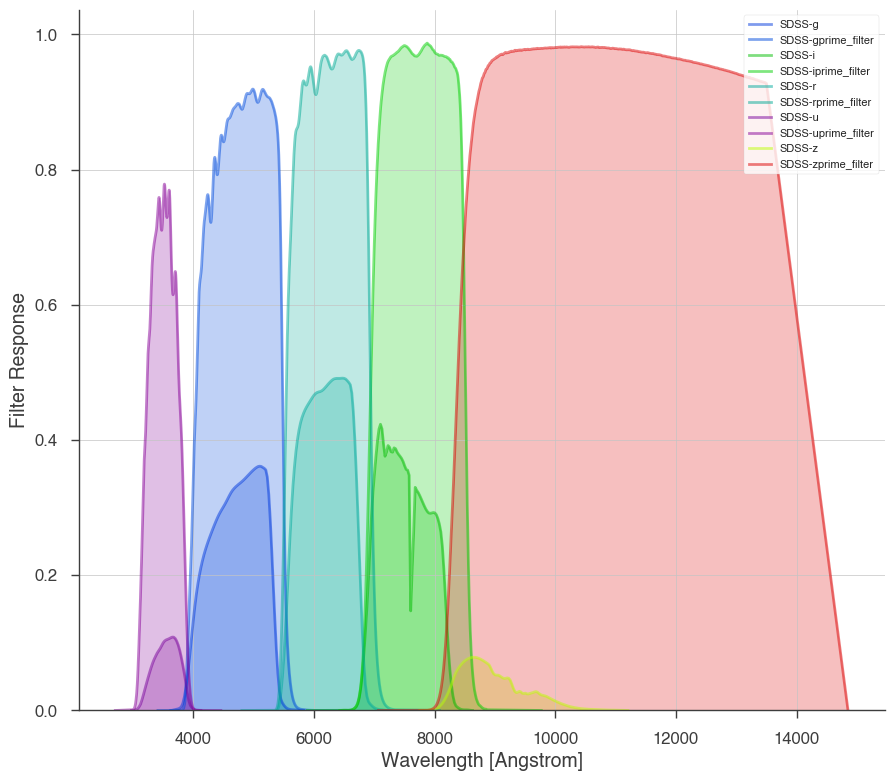

In [7]:
spec_filters.plot_filters(threeML_filter_library.SLOAN.SDSS)

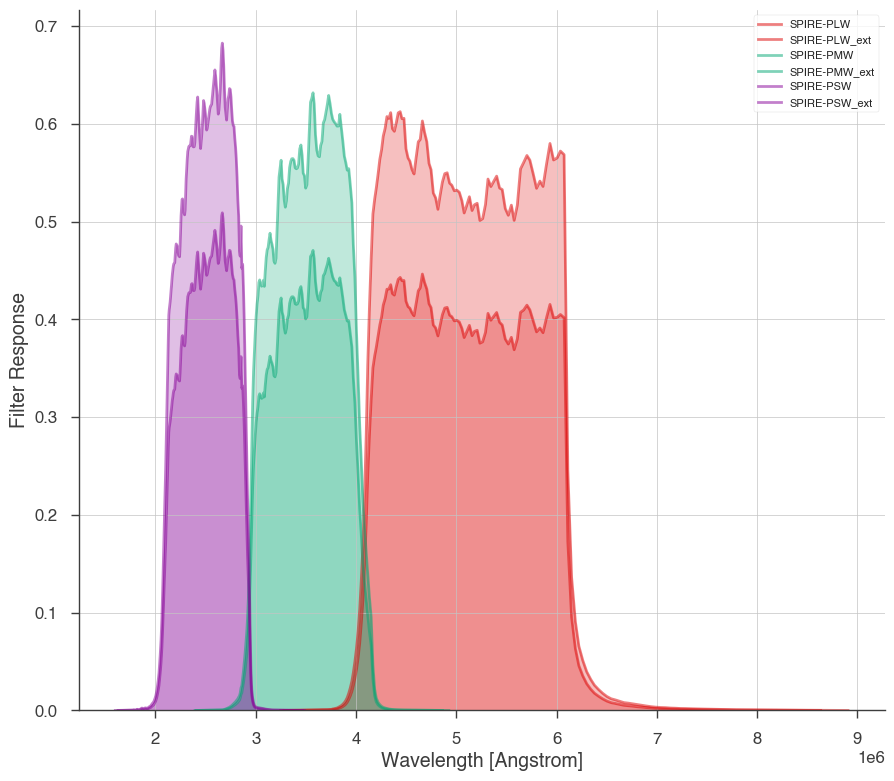

In [8]:
spec_filters.plot_filters(threeML_filter_library.Herschel.SPIRE)

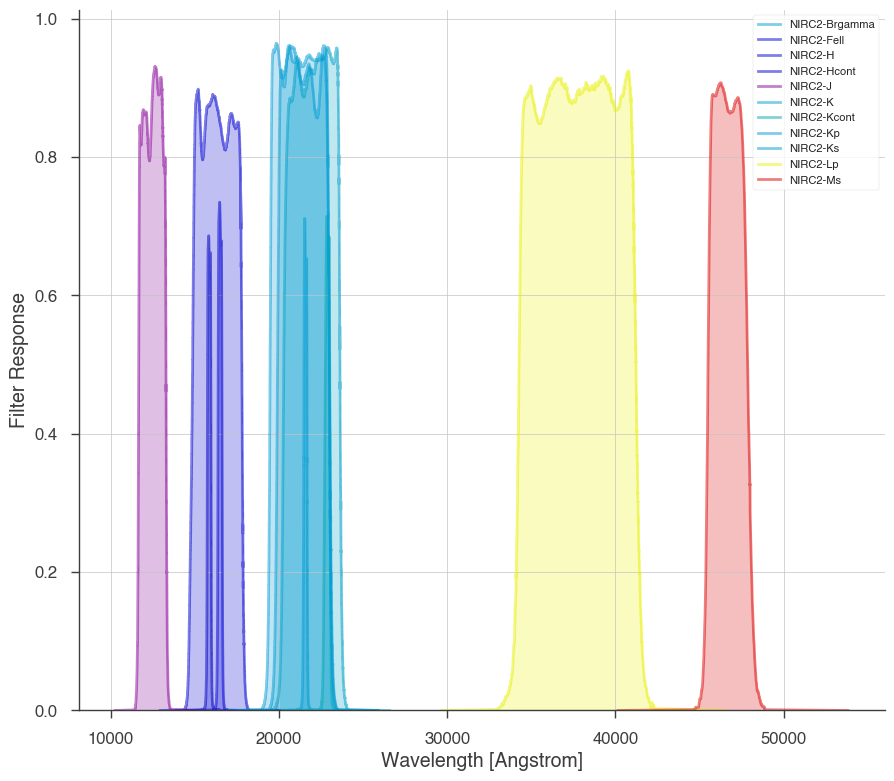

In [9]:
spec_filters.plot_filters(threeML_filter_library.Keck.NIRC2)

## Build your own filters

Following the example from speclite, we can build our own filters and add them:

16:47:51 INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=211003;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=542454;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

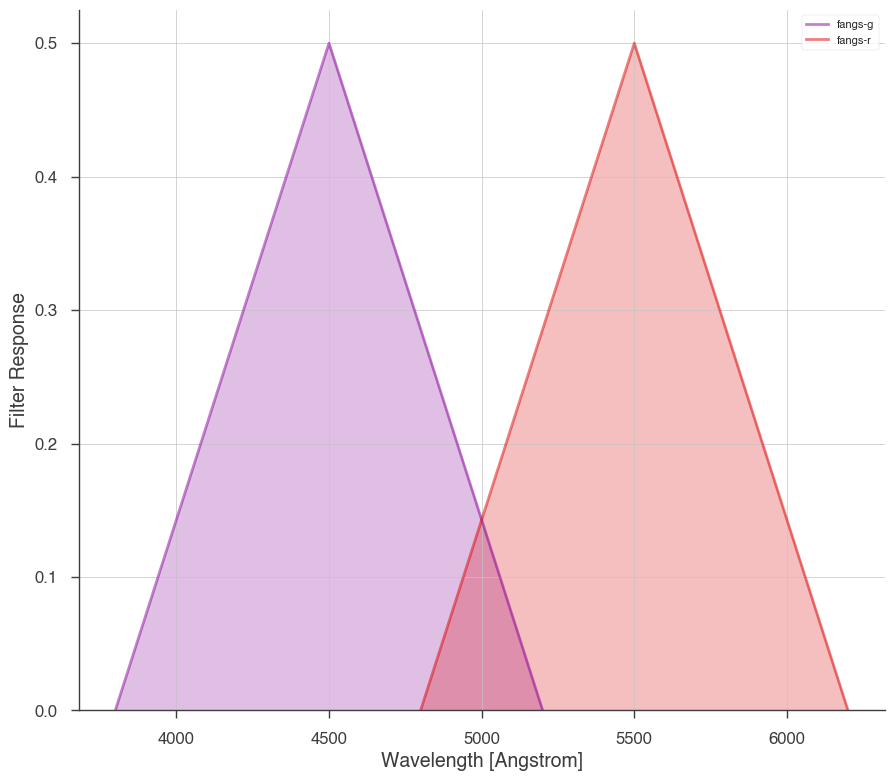

In [10]:
fangs_g = spec_filters.FilterResponse(
    wavelength=[3800, 4500, 5200] * u.Angstrom,
    response=[0, 0.5, 0],
    meta=dict(group_name="fangs", band_name="g"),
)
fangs_r = spec_filters.FilterResponse(
    wavelength=[4800, 5500, 6200] * u.Angstrom,
    response=[0, 0.5, 0],
    meta=dict(group_name="fangs", band_name="r"),
)

fangs = spec_filters.load_filters("fangs-g", "fangs-r")

fangslike = PhotometryLike.from_kwargs("fangs", filters=fangs, g=(20, 0.1), r=(18, 0.1))


_ = fangslike.display_filters()

## GROND Example

Now we will look at GROND. We get the filter from the 3ML filter library.

(Just play with tab completion to see what is available!)



In [11]:
grond = PhotometryLike.from_kwargs(
    "GROND",
    filters=threeML_filter_library.LaSilla.GROND,
    # g=(21.5.93,.23), # we exclude these filters
    # r=(22.,0.12),
    i=(21.8, 0.01),
    z=(21.2, 0.01),
    J=(19.6, 0.01),
    H=(18.6, 0.01),
    K=(18.0, 0.01),
)

         INFO      Using Gaussian statistic (equivalent to chi^2) with the provided errors.            ]8;id=298580;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=482614;file:///Users/runner/work/threeML/threeML/threeML/plugins/XYLike.py#93\93]8;;\

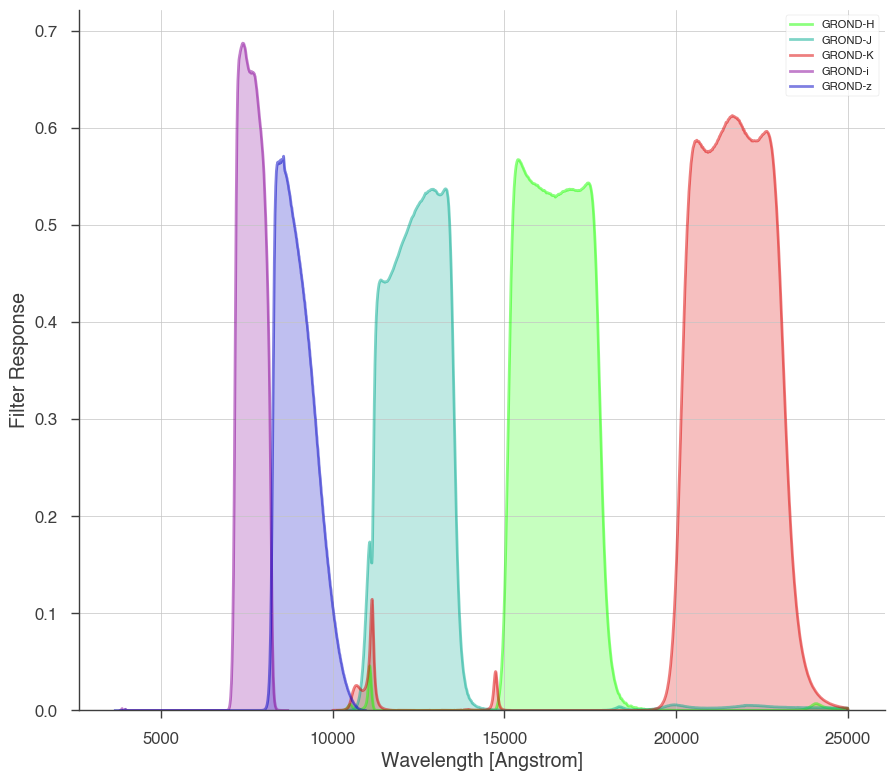

In [12]:
_ = grond.display_filters()

### Model specification

Here we use XSPEC's dust extinction models for the milky way and the host

In [13]:
spec = Powerlaw() * XS_zdust() * XS_zdust()

data_list = DataList(grond)

model = Model(PointSource("grb", 0, 0, spectral_shape=spec))

spec.piv_1 = 1e-2
spec.index_1.fix = False
spec.redshift_2 = 0.347
spec.redshift_2.fix = True

spec.e_bmv_2 = 5.0 / 2.93
spec.e_bmv_2.fix = True
spec.rv_2 = 2.93
spec.rv_2.fix = True


spec.method_2 = 3
spec.method_2.fix = True


spec.e_bmv_3 = 0.002 / 3.08
spec.e_bmv_3.fix = True
spec.rv_3 = 3.08
spec.rv_3.fix = True
spec.redshift_3 = 0
spec.redshift_3.fix = True
spec.method_3 = 1
spec.method_3.fix = True

jl = JointLikelihood(model, data_list)

16:47:52 INFO      set the minimizer to minuit                                             ]8;id=220510;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=811845;file:///Users/runner/work/threeML/threeML/threeML/classicMLE/joint_likelihood.py#1046\1046]8;;\

We compute $m_{\rm AB}$ from astromodels photon fluxes. This is done by convolving the differential flux over the filter response:

$F[R,f_\lambda] \equiv \int_0^\infty \frac{dg}{d\lambda}(\lambda)R(\lambda) \omega(\lambda) d\lambda$

where we have converted the astromodels functions to wavelength properly.

In [14]:
_ = jl.fit()

Best fit values:

,result,unit
parameter,,
grb.spectrum.main.composite.K_1,(4.60 +/- 0.12) x 10,1 / (cm2 keV s)
grb.spectrum.main.composite.index_1,-1.144 +/- 0.011,


Correlation matrix:

1.00,0.99
0.99,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
GROND,477.318107
total,477.318107


Values of statistical measures:

,statistical measures
AIC,964.636215
BIC,957.855091


We can now look at the fit in magnitude space or model space as with any plugin.


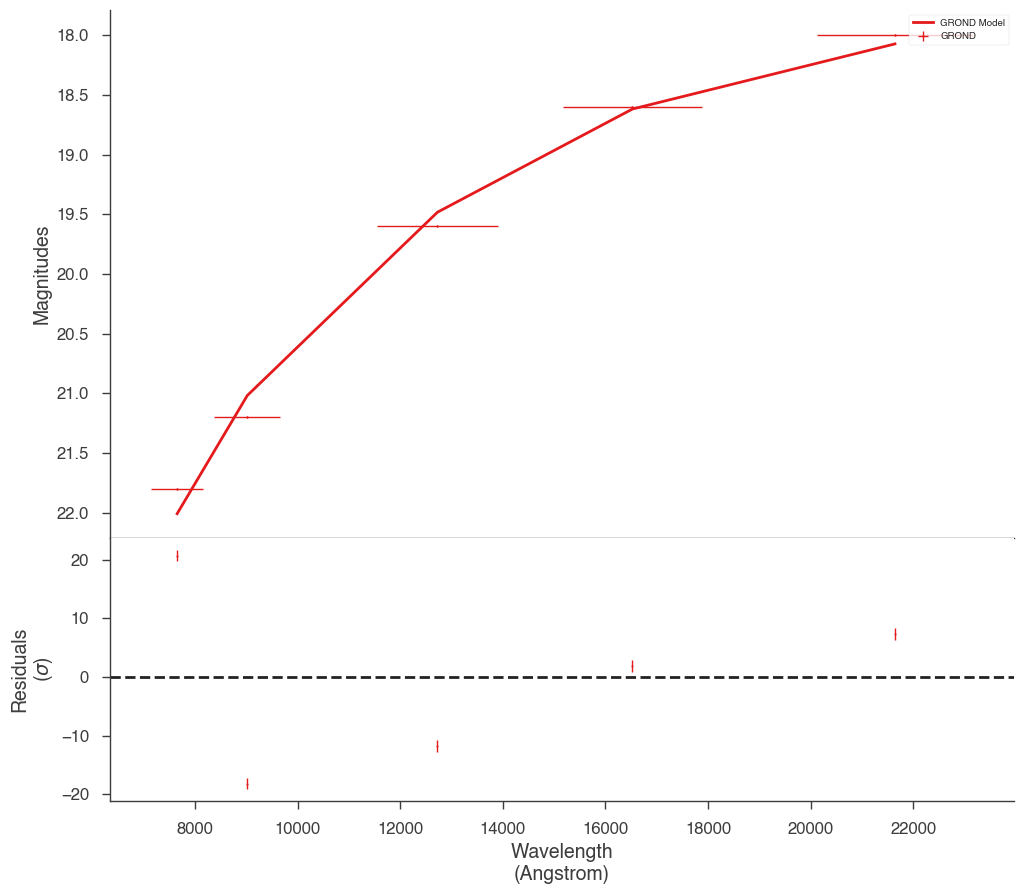

In [15]:
_ = display_photometry_model_magnitudes(jl)

processing MLE analyses:   0%|          | 0/1 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/200 [00:00<?, ?it/s]

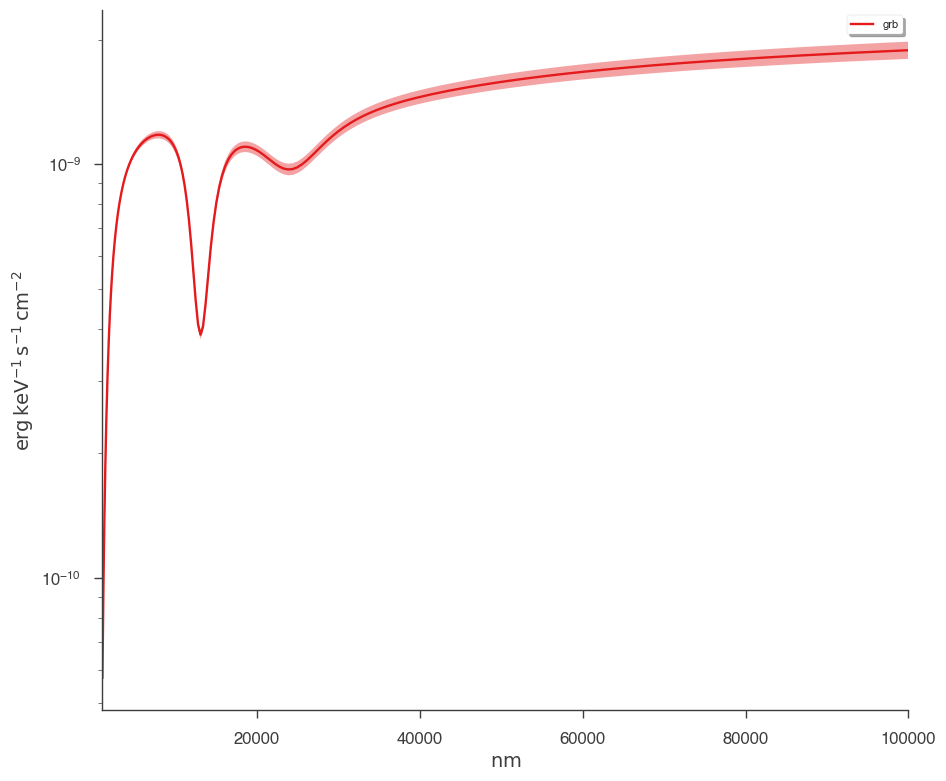

In [16]:
_ = plot_spectra(
    jl.results,
    flux_unit="erg/(cm2 s keV)",
    xscale="linear",
    energy_unit="nm",
    ene_min=1e3,
    ene_max=1e5,
    num_ene=200,
)